In [2]:
from pathlib import Path
import shutil
import pandas as pd
import random
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import time

# 1. 设置字体为 "黑体" (SimHei) 或 "微软雅黑" (Microsoft YaHei)
plt.rcParams['font.sans-serif'] = ['SimHei'] 

# 2. 解决负号显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# FG 音频根目录（你之前已经填过的话保持不变）
FG_WAV_ROOT = Path(r"X:\数据集\OceanShip_1\OceanShip-FG")
CG_WAV_ROOT = Path(r"X:\数据集\OceanShip_1\OceanShip-CG")

# FG 标注文件（GitHub 上的那两个）
FG_META_FILES = [
    Path(r"X:\数据集\OceanShip_1\oceanship_fg_train.csv"),
    Path(r"X:\数据集\OceanShip_1\oceanship_fg_test.csv"),
]

# CG 标注文件——现在就只有这一个
CG_META_FILES = [
    Path(r"X:\数据集\OceanShip_1\OceanShip-CG\label.csv"),
]

In [3]:
def load_expected_basenames(meta_files, wav_col_candidates=None):
    """
    从若干个标注文件中，抽取“期望存在的 wav 文件名集合”
    """
    if wav_col_candidates is None:
        # 把可能的列名多放几个，兼容 CG 的 label.csv
        wav_col_candidates = [
            "wav_path", "file", "filename", "wav", "path",
            "audio", "audio_path", "audio_file", "name"
        ]

    dfs = []
    used_col = None

    for meta_path in meta_files:
        df = pd.read_csv(meta_path)
        print(f"\n[INFO] 读取标注文件: {meta_path}")
        print("[INFO] 列名：", list(df.columns))

        # 自动探测哪一列是 wav 路径
        col = None
        for c in wav_col_candidates:
            if c in df.columns:
                col = c
                break
        if col is None:
            raise ValueError(
                f"在标注文件 {meta_path} 中找不到 wav 路径列，"
                f"请查看该 csv 的列名，并在 wav_col_candidates 中加上正确列名。"
            )
        if used_col is None:
            used_col = col
        print(f"[INFO] 使用列 '{col}' 作为 wav 路径")

        sub = df[[col]].copy()
        sub["basename"] = sub[col].astype(str).apply(lambda p: Path(p).name)
        dfs.append(sub[["basename"]])

    all_df = pd.concat(dfs, ignore_index=True)

    # 查重
    dup_counts = all_df["basename"].value_counts()
    duplicates = dup_counts[dup_counts > 1]

    expected = set(all_df["basename"])
    print(f"\n[INFO] 标注中共出现 {len(expected)} 个唯一 wav 文件名，总行数 {len(all_df)}，"
          f"其中重复文件名 {len(duplicates)} 个")

    return expected, duplicates


def scan_wav_basenames(wav_root: Path):
    """
    扫描目录下所有 wav，返回 basenames 集合和路径列表
    """
    wav_paths = list(wav_root.rglob("*.wav"))
    basenames = {p.name for p in wav_paths}
    print(f"[INFO] {wav_root} 下扫描到 {len(wav_paths)} 个 wav 文件，"
          f"其中 {len(basenames)} 个唯一文件名")
    return basenames, wav_paths


In [9]:
def load_expected_stems(meta_files, wav_col="wav_path"):
    stems = []
    for meta_path in meta_files:
        df = pd.read_csv(meta_path)
        s = df[wav_col].astype(str).apply(lambda p: Path(p).stem)
        stems.append(s)
        print(f"[INFO] {meta_path} 使用列 '{wav_col}'，共 {len(s)} 条")
    all_stems = pd.concat(stems, ignore_index=True)
    unique_stems = set(all_stems.tolist())
    return unique_stems

def scan_wav_stems(wav_root: Path):
    wav_paths = list(wav_root.rglob("*.wav"))
    stems = {p.stem for p in wav_paths}
    print(f"[INFO] {wav_root} 下扫描到 {len(wav_paths)} 个 wav，{len(stems)} 个唯一 stem")
    return stems, wav_paths

# FG 检查
fg_expected_stems = load_expected_stems(FG_META_FILES, wav_col="wav_path")
fg_actual_stems, fg_paths = scan_wav_stems(FG_WAV_ROOT)

fg_missing_stems = sorted(fg_expected_stems - fg_actual_stems)
fg_extra_stems   = sorted(fg_actual_stems - fg_expected_stems)

print(f"[FG] 期望 stem 数量: {len(fg_expected_stems)}")
print(f"[FG] 实际 stem 数量: {len(fg_actual_stems)}")
print(f"[FG] 缺失 stem: {len(fg_missing_stems)}")
print(f"[FG] 多余 stem: {len(fg_extra_stems)}")
print("前 10 个缺失 stem:", fg_missing_stems[:10])
print("前 10 个多余 stem:", fg_extra_stems[:10])

[INFO] X:\数据集\OceanShip_1\oceanship_fg_train.csv 使用列 'wav_path'，共 45699 条
[INFO] X:\数据集\OceanShip_1\oceanship_fg_test.csv 使用列 'wav_path'，共 8071 条
[INFO] X:\数据集\OceanShip_1\OceanShip-FG 下扫描到 53770 个 wav，53770 个唯一 stem
[FG] 期望 stem 数量: 53770
[FG] 实际 stem 数量: 53770
[FG] 缺失 stem: 0
[FG] 多余 stem: 0
前 10 个缺失 stem: []
前 10 个多余 stem: []


In [ ]:
def load_expected_stems(meta_files, wav_col):
    """
    从若干个标注文件中，抽取“期望存在的 wav 文件名 stem 集合”
    wav_col: 标注文件中表示音频路径/文件名的列名，比如 'wav_path' 或 'path'
    """
    stems = []
    for meta_path in meta_files:
        df = pd.read_csv(meta_path)
        print(f"[INFO] 读取标注文件: {meta_path}")
        print("[INFO] 列名：", list(df.columns))
        if wav_col not in df.columns:
            raise ValueError(f"{meta_path} 中找不到列 '{wav_col}'，请检查列名。")
        s = df[wav_col].astype(str).apply(lambda p: Path(p).stem)
        stems.append(s)
        print(f"[INFO] 使用列 '{wav_col}'，共 {len(s)} 条")

    all_stems = pd.concat(stems, ignore_index=True)
    unique_stems = set(all_stems.tolist())
    print(f"[INFO] 标注中共出现 {len(unique_stems)} 个唯一 stem")
    return unique_stems


def scan_wav_stems(wav_root: Path):
    """
    扫描目录下所有 wav，返回 stem 集合和完整路径列表
    """
    wav_paths = list(wav_root.rglob("*.wav"))
    stems = {p.stem for p in wav_paths}
    print(f"[INFO] {wav_root} 下扫描到 {len(wav_paths)} 个 wav，{len(stems)} 个唯一 stem")
    return stems, wav_paths

# 从 label.csv 中读出期望存在的 stem
cg_expected_stems = load_expected_stems(
    CG_META_FILES,
    wav_col="path"
)

# 扫描目录里的 .wav，取 stem
cg_actual_stems, cg_paths = scan_wav_stems(CG_WAV_ROOT)

# 差集比较
cg_missing = sorted(cg_expected_stems - cg_actual_stems)  # 标注有，目录没有
cg_extra   = sorted(cg_actual_stems - cg_expected_stems)  # 目录有，标注没有

print(f"\n[CG] 标注中期望的 stem 数量: {len(cg_expected_stems)}")
print(f"[CG] 实际 stem 数量: {len(cg_actual_stems)}")
print(f"[CG] 缺失 stem: {len(cg_missing)}")
print(f"[CG] 多余 stem: {len(cg_extra)}\n")

print("前 10 个缺失 stem：", cg_missing[:10])
print("前 10 个多余 stem：", cg_extra[:10])

[INFO] 读取标注文件: X:\数据集\OceanShip_1\OceanShip-CG\label.csv
[INFO] 列名： ['label', 'path']
[INFO] 使用列 'path'，共 49153 条
[INFO] 标注中共出现 49153 个唯一 stem
[INFO] X:\数据集\OceanShip_1\OceanShip-CG 下扫描到 49153 个 wav，49153 个唯一 stem

[CG] 标注中期望的 stem 数量: 49153
[CG] 实际 stem 数量: 49153
[CG] 缺失 stem: 0
[CG] 多余 stem: 0

前 10 个缺失 stem： []
前 10 个多余 stem： []


In [11]:
# ================= 配置路径 (请根据实际情况修改) =================
# 1. Full (全集) 标注文件
FULL_TRAIN_CSV = Path(r"X:\数据集\OceanShip_2\oceanship_full_train.csv")
FULL_TEST_CSV  = Path(r"X:\数据集\OceanShip_2\oceanship_full_test.csv")

# 2. FG (细粒度) 标注文件
FG_TRAIN_CSV   = Path(r"X:\数据集\OceanShip_1\oceanship_fg_train.csv")
FG_TEST_CSV    = Path(r"X:\数据集\OceanShip_1\oceanship_fg_test.csv")

# 3. CG (粗粒度) 标注文件
CG_LABEL_CSV   = Path(r"X:\数据集\OceanShip_1\OceanShip-CG\label.csv")

# ================= 核心工具函数 =================
def get_stems(csv_path, possible_cols=['wav_path', 'path', 'filename']):
    """读取 CSV 并提取文件名的 stem (不含后缀) 作为唯一标识 ID"""
    if not csv_path.exists():
        print(f"[错误] 文件不存在: {csv_path}")
        return set()
    
    df = pd.read_csv(csv_path)
    
    # 自动找列名
    target_col = None
    for col in possible_cols:
        if col in df.columns:
            target_col = col
            break
            
    if not target_col:
        raise ValueError(f"在 {csv_path.name} 中找不到路径列，列名为: {list(df.columns)}")
        
    # 提取 stem
    stems = set(df[target_col].astype(str).apply(lambda x: Path(x).stem))
    return stems

# ================= 开始核查 =================
print(">>> 正在加载数据并提取唯一标识 (Stems)...")

# 1. 加载 Full
s_full_train = get_stems(FULL_TRAIN_CSV)
s_full_test  = get_stems(FULL_TEST_CSV)
s_full_all   = s_full_train | s_full_test

# 2. 加载 FG
s_fg_train   = get_stems(FG_TRAIN_CSV)
s_fg_test    = get_stems(FG_TEST_CSV)
s_fg_all     = s_fg_train | s_fg_test

# 3. 加载 CG
s_cg_all     = get_stems(CG_LABEL_CSV)

print(f"\n{'='*20} 数量统计 {'='*20}")
print(f"Full (Train + Test): {len(s_full_train)} + {len(s_full_test)} = {len(s_full_all)}")
print(f"FG   (Train + Test): {len(s_fg_train)} + {len(s_fg_test)} = {len(s_fg_all)}")
print(f"CG   (Total)       : {len(s_cg_all)}")

# 4. 构建理论上的全集 (FG + CG)
s_theoretical_all = s_fg_all | s_cg_all

print(f"\n{'='*20} 逻辑一致性核查 {'='*20}")

# --- 核查 1: FG 和 CG 是否有重叠? (应当无重叠) ---
intersection = s_fg_all & s_cg_all
if len(intersection) == 0:
    print("[PASS] ✅ FG 和 CG 互斥 (无重复样本)。")
else:
    print(f"[FAIL] ❌ FG 和 CG 存在 {len(intersection)} 个重复样本！")

# --- 核查 2: Full 是否等于 FG + CG? ---
missing_in_full = s_theoretical_all - s_full_all  # FG/CG 有，但 Full 没收录
extra_in_full   = s_full_all - s_theoretical_all  # Full 有，但 FG/CG 没找到

if len(missing_in_full) == 0 and len(extra_in_full) == 0:
    print("[PASS] ✅ Full 数据集完美等于 FG + CG 的总和。")
    print(f"        Full ({len(s_full_all)}) == FG ({len(s_fg_all)}) + CG ({len(s_cg_all)})")
else:
    print("[FAIL] ❌ 集合不匹配！")
    if missing_in_full:
        print(f"   - 警告: {len(missing_in_full)} 个样本在 FG/CG 中存在，但在 Full 中丢失。")
    if extra_in_full:
        print(f"   - 警告: {len(extra_in_full)} 个样本在 Full 中存在，但来源不明 (非FG非CG)。")

# --- 核查 3: 训练集/测试集的成分分析 ---
print(f"\n{'='*20} 深入分析 Full 的构成 {'='*20}")
# 看看 Full 的训练集中，包含了多少 FG 和 CG
full_train_from_fg = s_full_train & s_fg_all
full_train_from_cg = s_full_train & s_cg_all

# 看看 Full 的测试集中，包含了多少 FG 和 CG
full_test_from_fg = s_full_test & s_fg_all
full_test_from_cg = s_full_test & s_cg_all

print(f"Full 训练集 ({len(s_full_train)}) 构成:")
print(f"   - 来自 FG: {len(full_train_from_fg)}")
print(f"   - 来自 CG: {len(full_train_from_cg)}")

print(f"Full 测试集 ({len(s_full_test)}) 构成:")
print(f"   - 来自 FG: {len(full_test_from_fg)}")
print(f"   - 来自 CG: {len(full_test_from_cg)}")

# 校验总和
if (len(full_train_from_fg) + len(full_train_from_cg) == len(s_full_train)) and \
   (len(full_test_from_fg) + len(full_test_from_cg) == len(s_full_test)):
     print("\n[结论] ✅ Full 数据集的每一条数据来源都清晰明确。")
else:
     print("\n[结论] ❌ Full 数据集中包含未知的第三方数据。")

>>> 正在加载数据并提取唯一标识 (Stems)...

==================== 数量统计 ====================
Full (Train + Test): 83920 + 15155 = 97664
FG   (Train + Test): 45699 + 8071 = 53770
CG   (Total)       : 49153

==================== 逻辑一致性核查 ====================
[FAIL] ❌ FG 和 CG 存在 5259 个重复样本！
[PASS] ✅ Full 数据集完美等于 FG + CG 的总和。
        Full (97664) == FG (53770) + CG (49153)

==================== 深入分析 Full 的构成 ====================
Full 训练集 (83920) 构成:
   - 来自 FG: 46835
   - 来自 CG: 42049
Full 测试集 (15155) 构成:
   - 来自 FG: 8346
   - 来自 CG: 8515

[结论] ❌ Full 数据集中包含未知的第三方数据。


In [12]:
# ================= 1. 配置路径 (请确认你的实际路径) =================
# 目标：需要检查的 Train 文件夹 (OceanShip_2)
TRAIN_DIR_BAD = Path(r"X:\数据集\OceanShip_2\Oceanship_train")
# 索引：官方的 Full Train CSV
TRAIN_CSV     = Path(r"X:\数据集\OceanShip_2\oceanship_full_train.csv")

# 源头：原来的 FG 和 CG 文件夹 (OceanShip_1)
SOURCE_FG_DIR = Path(r"X:\数据集\OceanShip_1\OceanShip-FG")
SOURCE_CG_DIR = Path(r"X:\数据集\OceanShip_1\OceanShip-CG")

# ================= 2. 核心工具函数 =================
def get_stems_from_dir(dir_path):
    """扫描目录下的 wav 文件，返回 {stem: full_path} 的字典"""
    if not dir_path.exists():
        print(f"[错误] 找不到目录: {dir_path}")
        return {}
    # 使用字典同时保存 stem 和 完整路径，方便后续定位
    return {p.stem: p for p in dir_path.rglob("*.wav")}

def get_stems_from_csv(csv_path):
    """从 CSV 读取期望的 stem 集合"""
    df = pd.read_csv(csv_path)
    # 假设列名是 'wav_path'，如果报错请改为 'path' 或其他
    col_name = 'wav_path' if 'wav_path' in df.columns else 'path'
    return set(df[col_name].apply(lambda x: Path(x).stem))

# ================= 3. 开始执行搜救任务 =================
print(">>> 正在读取 CSV 和扫描硬盘，请稍候...")

# A. 获取“应该有”的名单
expected_stems = get_stems_from_csv(TRAIN_CSV)
print(f"[1] CSV 期望文件数 : {len(expected_stems)}")

# B. 获取“实际有”的名单 (Oceanship_train)
current_train_files = get_stems_from_dir(TRAIN_DIR_BAD)
current_train_stems = set(current_train_files.keys())
print(f"[2] Train 实际文件数: {len(current_train_stems)}")

# C. 计算缺失名单
missing_stems = expected_stems - current_train_stems
print(f"[3] 缺失文件总数   : {len(missing_stems)}")

if len(missing_stems) == 0:
    print("\n✅ 完美！没有缺失文件。")
else:
    print("\n>>> 正在去 FG 和 CG 源文件夹里寻找下落...")
    
    # D. 扫描源文件夹
    fg_files = get_stems_from_dir(SOURCE_FG_DIR)
    cg_files = get_stems_from_dir(SOURCE_CG_DIR)
    
    fg_stems = set(fg_files.keys())
    cg_stems = set(cg_files.keys())
    
    # E. 交叉核对
    found_in_fg = missing_stems & fg_stems
    found_in_cg = missing_stems & cg_stems
    found_in_both = found_in_fg & found_in_cg
    
    # 计算能找回的总数 (并集)
    recoverable = found_in_fg | found_in_cg
    truly_lost  = missing_stems - recoverable
    
    print(f"{'='*30}")
    print(f"搜救报告 (缺失总数: {len(missing_stems)})")
    print(f"{'='*30}")
    print(f"✅ 在 FG 中找到 : {len(found_in_fg)} 个")
    print(f"✅ 在 CG 中找到 : {len(found_in_cg)} 个")
    print(f"   (其中 {len(found_in_both)} 个同时存在于 FG 和 CG)")
    print(f"{'-'*30}")
    print(f"🎉 可恢复总数   : {len(recoverable)} 个 (占比 {len(recoverable)/len(missing_stems):.1%})")
    print(f"❌ 彻底丢失     : {len(truly_lost)} 个")
    
    # F. 打印一些样例
    if len(truly_lost) > 0:
        print("\n[警告] 以下文件在 FG 和 CG 里都找不到 (可能是原始数据本身就缺失):")
        print(list(truly_lost)[:5])
    
    if len(recoverable) > 0:
        print("\n[提示] 可以在下一步通过脚本将找到的文件复制过去。")

>>> 正在读取 CSV 和扫描硬盘，请稍候...
[1] CSV 期望文件数 : 83920
[2] Train 实际文件数: 68399
[3] 缺失文件总数   : 15521

>>> 正在去 FG 和 CG 源文件夹里寻找下落...
搜救报告 (缺失总数: 15521)
✅ 在 FG 中找到 : 6385 个
✅ 在 CG 中找到 : 9522 个
   (其中 386 个同时存在于 FG 和 CG)
------------------------------
🎉 可恢复总数   : 15521 个 (占比 100.0%)
❌ 彻底丢失     : 0 个

[提示] 可以在下一步通过脚本将找到的文件复制过去。


In [ ]:
# ================= 1. 配置路径 =================
# 目标：需要检查的 Test 文件夹 (推测在 OceanShip_2 下)
TEST_DIR_BAD = Path(r"X:\数据集\OceanShip_2\Oceanship_test")

# 索引：官方的 Full Test CSV
TEST_CSV = Path(r"X:\数据集\OceanShip_2\oceanship_full_test.csv")

# 源头：原来的 FG 和 CG 文件夹 (保持不变)
SOURCE_FG_DIR = Path(r"X:\数据集\OceanShip_1\OceanShip-FG")
SOURCE_CG_DIR = Path(r"X:\数据集\OceanShip_1\OceanShip-CG")

# ================= 2. 核心工具函数 (与之前一致) =================
def get_stems_from_dir(dir_path):
    """扫描目录下的 wav 文件，返回 {stem: full_path} 的字典"""
    if not dir_path.exists():
        print(f"[错误] 找不到目录: {dir_path}")
        return {}
    return {p.stem: p for p in dir_path.rglob("*.wav")}

def get_stems_from_csv(csv_path):
    """从 CSV 读取期望的 stem 集合"""
    if not csv_path.exists():
         print(f"[错误] 找不到 CSV: {csv_path}")
         return set()
    df = pd.read_csv(csv_path)
    col_name = 'wav_path' if 'wav_path' in df.columns else 'path'
    return set(df[col_name].apply(lambda x: Path(x).stem))

# ================= 3. 开始执行搜救任务 (Test 集) =================
print(">>> [Test集] 正在读取 CSV 和扫描硬盘，请稍候...")

# A. 获取“应该有”的名单
expected_stems = get_stems_from_csv(TEST_CSV)
print(f"[1] CSV 期望文件数 : {len(expected_stems)}")

# B. 获取“实际有”的名单
current_test_files = get_stems_from_dir(TEST_DIR_BAD)
current_test_stems = set(current_test_files.keys())
print(f"[2] Test 实际文件数 : {len(current_test_stems)}")

# C. 计算缺失名单
missing_stems = expected_stems - current_test_stems
print(f"[3] 缺失文件总数   : {len(missing_stems)}")

if len(missing_stems) == 0:
    print("\n✅ 完美！Test 集没有缺失文件。")
else:
    print("\n>>> 正在去 FG 和 CG 源文件夹里寻找下落...")
    
    # D. 扫描源文件夹
    fg_files = get_stems_from_dir(SOURCE_FG_DIR)
    cg_files = get_stems_from_dir(SOURCE_CG_DIR)
    
    fg_stems = set(fg_files.keys())
    cg_stems = set(cg_files.keys())
    
    # E. 交叉核对
    found_in_fg = missing_stems & fg_stems
    found_in_cg = missing_stems & cg_stems
    
    # 计算能找回的总数
    recoverable = found_in_fg | found_in_cg
    truly_lost  = missing_stems - recoverable
    
    print(f"{'='*30}")
    print(f"搜救报告 (Test 缺失总数: {len(missing_stems)})")
    print(f"{'='*30}")
    print(f"✅ 在 FG 中找到 : {len(found_in_fg)} 个")
    print(f"✅ 在 CG 中找到 : {len(found_in_cg)} 个")
    print(f"{'-'*30}")
    print(f"🎉 可恢复总数   : {len(recoverable)} 个")
    print(f"❌ 彻底丢失     : {len(truly_lost)} 个")
    
    if len(truly_lost) > 0:
        print("\n[警告] 以下文件在 FG 和 CG 里都找不到 (需要从 CSV 中剔除):")
        print(list(truly_lost)[:5])

>>> [Test集] 正在读取 CSV 和扫描硬盘，请稍候...
[1] CSV 期望文件数 : 15155
[2] Test 实际文件数 : 15155
[3] 缺失文件总数   : 0

✅ 完美！Test 集没有缺失文件。


In [15]:
# ================= 配置路径 =================
# 1. 目的地：缺失文件的 Train 文件夹
DEST_TRAIN_DIR = Path(r"X:\数据集\OceanShip_2\Oceanship_train")

# 2. 索引：官方 Full Train CSV (用来知道缺了谁)
TRAIN_CSV = Path(r"X:\数据集\OceanShip_2\oceanship_full_train.csv")

# 3. 补给站：源 FG 和 CG 文件夹
SOURCE_DIRS = [
    Path(r"X:\数据集\OceanShip_1\OceanShip-FG"),
    Path(r"X:\数据集\OceanShip_1\OceanShip-CG")
]

# ================= 核心逻辑 =================
print(">>> 正在初始化修复程序...")

# 1. 读取需要的所有 stem
df = pd.read_csv(TRAIN_CSV)
# 兼容列名
col = 'wav_path' if 'wav_path' in df.columns else 'path'
expected_stems = set(df[col].apply(lambda x: Path(x).stem))
print(f"[目标] 训练集应包含: {len(expected_stems)} 个唯一文件")

# 2. 扫描现有的 stem
current_files = {p.stem for p in DEST_TRAIN_DIR.glob("*.wav")}
missing_stems = expected_stems - current_files
print(f"[现状] 当前缺失数量: {len(missing_stems)}")

if len(missing_stems) == 0:
    print("✅ 训练集已经完整，无需修复！")
else:
    print(f">>> 开始从源文件夹搜寻并复制 {len(missing_stems)} 个文件...")
    
    # 3. 建立源文件索引 (stem -> full_path)
    #    为了加快速度，先扫一遍源目录
    source_map = {}
    for src_dir in SOURCE_DIRS:
        if src_dir.exists():
            print(f"    正在索引源目录: {src_dir} ...")
            for p in src_dir.rglob("*.wav"):
                source_map[p.stem] = p
        else:
            print(f"    [警告] 源目录不存在: {src_dir}")

    # 4. 执行复制
    success_count = 0
    fail_count = 0
    
    # 使用 tqdm 显示进度
    for stem in tqdm(missing_stems, desc="修复进度"):
        if stem in source_map:
            src_file = source_map[stem]
            dst_file = DEST_TRAIN_DIR / src_file.name
            try:
                shutil.copy2(src_file, dst_file)
                success_count += 1
            except Exception as e:
                print(f"    [复制失败] {src_file.name}: {e}")
                fail_count += 1
        else:
            # 源里也找不到（那是真的丢了）
            fail_count += 1
            
    print(f"\n{'='*30}")
    print(f"修复完成报告")
    print(f"{'='*30}")
    print(f"✅ 成功修复: {success_count} 个文件")
    print(f"❌ 无法找回: {fail_count} 个文件 (可能源文件中也不存在)")
    print(f"当前 Train 文件夹总数: {len(list(DEST_TRAIN_DIR.glob('*.wav')))}")

>>> 正在初始化修复程序...
[目标] 训练集应包含: 83920 个唯一文件
[现状] 当前缺失数量: 15521
>>> 开始从源文件夹搜寻并复制 15521 个文件...
    正在索引源目录: X:\数据集\OceanShip_1\OceanShip-FG ...
    正在索引源目录: X:\数据集\OceanShip_1\OceanShip-CG ...


修复进度: 100%|██████████| 15521/15521 [01:40<00:00, 153.81it/s]



修复完成报告
✅ 成功修复: 15521 个文件
❌ 无法找回: 0 个文件 (可能源文件中也不存在)
当前 Train 文件夹总数: 83920


# Train文件夹标注去重处理

In [16]:
# 1. 配置路径：根据你本地情况修改
META_CSV = Path(r"X:\数据集\OceanShip_2\oceanship_full_train.csv")
WAV_ROOT = Path(r"X:\数据集\OceanShip_2\Oceanship_train")

WAV_COL_NAME = "wav_path"  # 标注中表示音频路径的列名

# 2. 读取标注，统计行数和唯一 stem 数
df = pd.read_csv(META_CSV)
print("标注列名：", list(df.columns))
print("原标注行数：", len(df))

# 取 stem（去掉目录和后缀）
df["stem"] = df[WAV_COL_NAME].astype(str).apply(lambda p: Path(p).stem)

expected_stems = df["stem"]
expected_stem_set = set(expected_stems.tolist())
print("标注中的唯一 stem 数量：", len(expected_stem_set))

# 3. 扫描 train 目录下所有 wav，统计实际 stem 集合
wav_paths = list(WAV_ROOT.rglob("*.wav"))
actual_stem_set = {p.stem for p in wav_paths}

print(f"\n{WAV_ROOT} 下共找到 {len(wav_paths)} 个 wav 文件，"
      f"{len(actual_stem_set)} 个唯一 stem。")

# 4. 计算差集：缺失 / 多余
missing_stems = sorted(expected_stem_set - actual_stem_set)  # 标注有，目录没有
extra_stems   = sorted(actual_stem_set - expected_stem_set)  # 目录有，标注没有

print("\n[Train 检查结果]")
print(f"标注期望的 stem 数量: {len(expected_stem_set)}")
print(f"实际 wav stem 数量: {len(actual_stem_set)}")
print(f"缺失的 wav 数量: {len(missing_stems)}")
print(f"多余的 wav 数量: {len(extra_stems)}")

print("\n前 10 个缺失的 stem：", missing_stems[:10])
print("前 10 个多余的 stem：", extra_stems[:10])

标注列名： ['wav_path', 'label', 'text_path']
原标注行数： 87473
标注中的唯一 stem 数量： 83920

X:\数据集\OceanShip_2\Oceanship_train 下共找到 83920 个 wav 文件，83920 个唯一 stem。

[Train 检查结果]
标注期望的 stem 数量: 83920
实际 wav stem 数量: 83920
缺失的 wav 数量: 0
多余的 wav 数量: 0

前 10 个缺失的 stem： []
前 10 个多余的 stem： []


In [19]:
TRAIN_CSV_PATH = r"X:\数据集\OceanShip_2\oceanship_full_train.csv"

df = pd.read_csv(TRAIN_CSV_PATH)
col = 'wav_path' if 'wav_path' in df.columns else 'path'

# 1. 创建临时的 Stem 列
df['temp_stem'] = df[col].apply(lambda x: Path(x).stem)

# 2. 基于 Stem 查找重复
dups = df[df.duplicated(subset=['temp_stem'], keep=False)].sort_values(by='temp_stem')

print(f"基于文件名(Stem)找到的重复记录数: {len(dups)}")
print("\n=== 重复样本对比 (请注意观察 wav_path 的区别) ===")
# 打印前 4 行，即 2 对重复样本
# 你会发现 wav_path 可能一个是 .../FG/...，一个是 .../CG/...
for i in range(0, min(4, len(dups))):
    row = dups.iloc[i]
    print(f"[{i}] Path: {row[col]}")
    print(f"    Stem: {row['temp_stem']}")
    print("-" * 30)

# 清理临时列（如果需要继续使用 df）
df.drop(columns=['temp_stem'], inplace=True)

基于文件名(Stem)找到的重复记录数: 7106

=== 重复样本对比 (请注意观察 wav_path 的区别) ===
[0] Path: ./3090latest_wav/20210107T131611.740Z_1644_id_24_typecargo_37_0.pt
    Stem: 20210107T131611.740Z_1644_id_24_typecargo_37_0
------------------------------
[1] Path: ./v100_preprocessed_89_09_31/20210107T131611.740Z_1644_id_24_typecargo_37_0.pt
    Stem: 20210107T131611.740Z_1644_id_24_typecargo_37_0
------------------------------
[2] Path: ./v100_preprocessed_89_09_31/20210107T131611.740Z_1644_id_24_typecargo_37_1.pt
    Stem: 20210107T131611.740Z_1644_id_24_typecargo_37_1
------------------------------
[3] Path: ./3090latest_wav/20210107T131611.740Z_1644_id_24_typecargo_37_1.pt
    Stem: 20210107T131611.740Z_1644_id_24_typecargo_37_1
------------------------------


In [24]:
# ================= 配置路径 =================
# 1. 原始混乱的 CSV
RAW_CSV_PATH = r"X:\数据集\OceanShip_2\oceanship_full_train.csv"

# 2. 你现在的真实音频目录 (仅用来验证文件是否存在，不会修改 CSV 路径)
REAL_WAV_DIR = Path(r"X:\数据集\OceanShip_2\Oceanship_train")

# 3. 输出的新 CSV 路径
OUTPUT_CSV_PATH = r"X:\数据集\OceanShip_2\oceanship_train_dedup.csv"

# ================= 执行修复 =================
print(">>> 开始生成去重版训练索引 (保留原路径)...")

# 1. 读取原始 CSV
df = pd.read_csv(RAW_CSV_PATH)
col = 'wav_path' if 'wav_path' in df.columns else 'path'
print(f"原始行数: {len(df)}")

# 2. 提取 Stem 并去重
# 逻辑：新增一列 stem，利用它去重，保留第一条记录
df['stem'] = df[col].apply(lambda x: Path(x).stem)
df_clean = df.drop_duplicates(subset=['stem'], keep='first').copy()
print(f"去重后行数: {len(df_clean)} (理论应为 83920)")

# 3. [已修改] 跳过路径修正步骤
print(">>>以此配置跳过路径修改，保留 CSV 中的原始路径 string...")
# 原有的 fix_path 逻辑已被移除，df_clean[col] 保持不变

# 4. 最终验证 (逻辑调整)
# 既然 CSV 里的路径和硬盘上的不一致（后缀/目录不同），我们不能直接检查 CSV 路径。
# 我们检查：CSV 里提到的这个 stem，在 REAL_WAV_DIR 里有没有对应的 .wav 文件？
print(">>> 正在验证音频文件是否存在 (基于 stem 匹配)...")

def check_real_file_exists(stem):
    # 无论 CSV 里写在哪，我们都去 REAL_WAV_DIR 里找对应的 .wav
    target_file = REAL_WAV_DIR / f"{stem}.wav"
    return target_file.exists()

exists_mask = df_clean['stem'].apply(check_real_file_exists)
valid_count = exists_mask.sum()

if valid_count == len(df_clean):
    print(f"✅ 完美！去重后的 {valid_count} 条记录在真实目录下都能找到对应的 .wav 文件。")
else:
    print(f"❌ 警告：有 {len(df_clean) - valid_count} 条记录在真实目录下找不到对应的 .wav 文件！")
    # 如果找不到真实文件，建议还是剔除，否则训练必报错
    # 如果你确定不想剔除，可以注释掉下面这行
    df_clean = df_clean[exists_mask]

# 5. 清理临时列并保存
df_clean.drop(columns=['stem'], inplace=True)
# encoding='utf-8-sig' 防止中文乱码
df_clean.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8-sig') 

print(f"\n已保存最终文件到: {OUTPUT_CSV_PATH}")
print(f"注意：生成的 CSV 中 '{col}' 列依然保持原始格式 (如 .pt 后缀或旧相对路径)。")
print("请确保你的 Dataset/DataLoader 代码能正确处理这些路径（例如手动拼接 root 目录或替换后缀）。")

>>> 开始生成去重版训练索引 (保留原路径)...
原始行数: 87473
去重后行数: 83920 (理论应为 83920)
>>>以此配置跳过路径修改，保留 CSV 中的原始路径 string...
>>> 正在验证音频文件是否存在 (基于 stem 匹配)...
✅ 完美！去重后的 83920 条记录在真实目录下都能找到对应的 .wav 文件。

已保存最终文件到: X:\数据集\OceanShip_2\oceanship_train_dedup.csv
注意：生成的 CSV 中 'wav_path' 列依然保持原始格式 (如 .pt 后缀或旧相对路径)。
请确保你的 Dataset/DataLoader 代码能正确处理这些路径（例如手动拼接 root 目录或替换后缀）。


In [6]:
# ================= 配置路径 =================
CSV_PATH = r"X:\数据集\OceanShip_2\oceanship_train_dedup.csv"

# ================= 执行统计 =================
if Path(CSV_PATH).exists():
    df = pd.read_csv(CSV_PATH)
    print(f"成功读取文件: {CSV_PATH}")
    
    # 1. 获取唯一类别
    if 'label' in df.columns:
        unique_labels = df['label'].unique()
        unique_labels.sort() # 排序方便查看
        
        # 2. 打印统计结果
        print(f"\n{'='*30}")
        print(f"📊 类别统计报告")
        print(f"{'='*30}")
        print(f"类别总数: {len(unique_labels)} 个")
        print(f"{'-'*30}")
        print("类别列表:")
        for idx, label in enumerate(unique_labels):
            # 统计该类别的样本数量
            count = len(df[df['label'] == label])
            print(f"{idx+1:02d}. {label:<25} (样本数: {count})")
            
        print(f"{'='*30}")
        
        # 3. 验证是否符合论文描述 (15类)
        if len(unique_labels) == 15:
            print("✅ 类别数量与论文描述 (15类) 完全一致。")
        else:
            print(f"⚠️ 注意：类别数量 ({len(unique_labels)}) 与论文描述 (15类) 不符。")
            
    else:
        print("[错误] CSV 文件中找不到 'label' 列，请检查列名。")
else:
    print(f"[错误] 找不到文件: {CSV_PATH}")

成功读取文件: X:\数据集\OceanShip_2\oceanship_train_dedup.csv

📊 类别统计报告
类别总数: 15 个
------------------------------
类别列表:
01. Anti-pollution equipment  (样本数: 18)
02. Cargo                     (样本数: 22598)
03. Diving ship               (样本数: 4)
04. Dredging                  (样本数: 45)
05. Fishing                   (样本数: 5599)
06. Military ship             (样本数: 6)
07. Passenger                 (样本数: 6145)
08. Pleasure Craft            (样本数: 12051)
09. Port Tender               (样本数: 1667)
10. Sailing                   (样本数: 1846)
11. Search and Rescue vessel  (样本数: 548)
12. Spare                     (样本数: 5)
13. Tanker                    (样本数: 129)
14. Towing                    (样本数: 11353)
15. Tug                       (样本数: 21906)
✅ 类别数量与论文描述 (15类) 完全一致。


# Test文件夹标注去重处理

In [ ]:
# 标注文件路径
META_CSV = Path(r"X:\数据集\OceanShip_2\oceanship_full_test.csv")

# wav 所在根目录
WAV_ROOT = Path(r"X:\数据集\OceanShip_2\Oceanship_test")

# 标注里表示音频路径的列名
WAV_COL_NAME = "wav_path"

# 读取标注文件
df = pd.read_csv(META_CSV)
print("标注列名：", list(df.columns))
assert WAV_COL_NAME in df.columns, f"列 {WAV_COL_NAME} 不在标注文件中！"

# 抽取 stem（去掉目录和后缀，只保留主文件名）
from pathlib import Path

expected_stems = df[WAV_COL_NAME].astype(str).apply(lambda p: Path(p).stem)
expected_stem_set = set(expected_stems.tolist())

print(f"标注中共有 {len(df)} 条记录，"
      f"{len(expected_stem_set)} 个唯一 stem。")

# 扫描目录下所有 .wav
wav_paths = list(WAV_ROOT.rglob("*.wav"))
actual_stem_set = {p.stem for p in wav_paths}

print(f"{WAV_ROOT} 下共找到 {len(wav_paths)} 个 wav 文件，"
      f"{len(actual_stem_set)} 个唯一 stem。")

# 计算差集
missing_stems = sorted(expected_stem_set - actual_stem_set)  # 标注有，目录没有
extra_stems   = sorted(actual_stem_set - expected_stem_set)  # 目录有，标注没有

print(f"\n[检查结果]")
print(f"标注期望的 stem 数量: {len(expected_stem_set)}")
print(f"实际 wav stem 数量: {len(actual_stem_set)}")
print(f"缺失的 wav 数量: {len(missing_stems)}")
print(f"多余的 wav 数量: {len(extra_stems)}")

print("\n前 10 个缺失的 stem：", missing_stems[:10])
print("前 10 个多余的 stem：", extra_stems[:10])

标注列名： ['wav_path', 'label', 'text_path']
标注中共有 15450 条记录，15155 个唯一 stem。
X:\数据集\OceanShip_2\Oceanship_test 下共找到 15155 个 wav 文件，15155 个唯一 stem。

[检查结果]
标注期望的 stem 数量: 15155
实际 wav stem 数量: 15155
缺失的 wav 数量: 0
多余的 wav 数量: 0

前 10 个缺失的 stem： []
前 10 个多余的 stem： []


In [16]:
META_CSV = Path(r"X:\数据集\OceanShip_2\oceanship_full_test.csv")
df = pd.read_csv(META_CSV)

# 取 stem
df["stem"] = df["wav_path"].astype(str).apply(lambda p: Path(p).stem)

# 统计每个 stem 出现次数
counts = df["stem"].value_counts()

print("总行数:", len(df))
print("唯一 stem 数:", counts.shape[0])
print("出现超过 1 次的 stem 数量:", (counts > 1).sum())

# 看看前几个重复的例子
dup_examples = counts[counts > 1].head(5).index.tolist()
print("\n示例：这些 stem 在标注中出现了多次：", dup_examples)

df_dup = df[df["stem"].isin(dup_examples)]
df_dup.head(10)

总行数: 15450
唯一 stem 数: 15155
出现超过 1 次的 stem 数量: 295

示例：这些 stem 在标注中出现了多次： ['20210201T000447.782Z_12_id_5_typecargo_60_0', '20210131T055900.157Z_795_id_5_typecargo_31', '20210202T112011.517Z_1827_id_5_typecargo_53', '20210202T112133.917Z_1829_id_5_typecargo_31_0', '20210202T112602.957Z_1842_id_5_typecargo_51']


,wav_path,label,text_path,stem
6267,./v100_preprocessed_89_09_31/20210131T055900.1...,Towing,./v100_preprocessed_89_09_31/20210131T055900.1...,20210131T055900.157Z_795_id_5_typecargo_31
6625,./v100_preprocessed_89_09_31/20210201T000447.7...,Passenger,./v100_preprocessed_89_09_31/20210201T000447.7...,20210201T000447.782Z_12_id_5_typecargo_60_0
7280,./v100_preprocessed_89_09_31/20210202T112011.5...,Port Tender,./v100_preprocessed_89_09_31/20210202T112011.5...,20210202T112011.517Z_1827_id_5_typecargo_53
7281,./v100_preprocessed_89_09_31/20210202T112133.9...,Towing,./v100_preprocessed_89_09_31/20210202T112133.9...,20210202T112133.917Z_1829_id_5_typecargo_31_0
7282,./v100_preprocessed_89_09_31/20210202T112602.9...,Search and Rescue vessel,./v100_preprocessed_89_09_31/20210202T112602.9...,20210202T112602.957Z_1842_id_5_typecargo_51
14351,./3090latest_wav/20210131T055900.157Z_795_id_5...,Towing,./3090latest_wav/20210131T055900.157Z_795_id_5...,20210131T055900.157Z_795_id_5_typecargo_31
14875,./3090latest_wav/20210201T000447.782Z_12_id_5_...,Passenger,./3090latest_wav/20210201T000447.782Z_12_id_5_...,20210201T000447.782Z_12_id_5_typecargo_60_0
15411,./3090latest_wav/20210202T112011.517Z_1827_id_...,Port Tender,./3090latest_wav/20210202T112011.517Z_1827_id_...,20210202T112011.517Z_1827_id_5_typecargo_53
15413,./3090latest_wav/20210202T112133.917Z_1829_id_...,Towing,./3090latest_wav/20210202T112133.917Z_1829_id_...,20210202T112133.917Z_1829_id_5_typecargo_31_0
15414,./3090latest_wav/20210202T112602.957Z_1842_id_...,Search and Rescue vessel,./3090latest_wav/20210202T112602.957Z_1842_id_...,20210202T112602.957Z_1842_id_5_typecargo_51


In [18]:
# 2. 读取标注，增加 stem 列（去掉目录和后缀）
df = pd.read_csv(META_CSV)
print("原标注列名：", list(df.columns))
print("原标注行数：", len(df))

df["stem"] = df["wav_path"].astype(str).apply(lambda p: Path(p).stem)

# 3. 扫描实际存在的 wav，得到合法 stem 集合
wav_paths = list(WAV_ROOT.rglob("*.wav"))
wav_stems = {p.stem for p in wav_paths}
print("实际 wav 数量：", len(wav_paths))
print("实际唯一 stem 数量：", len(wav_stems))

# 4. 只保留“确实有对应 wav”的标注行（一般都会全部保留，这一步是安全检查）
df_valid = df[df["stem"].isin(wav_stems)].copy()
print("与 wav 匹配后的标注行数：", len(df_valid))

# 5. 按 stem 去重：同一个 wav 只保留一行标注
#    这里 keep='first' 表示保留第一次出现的那一条，你也可以改成 'last'
df_dedup = (
    df_valid
    .sort_values("stem")             # 先按 stem 排一下
    .drop_duplicates("stem", keep="first")
)

print("去重后的标注行数：", len(df_dedup))

# 6. 去掉临时的 stem 列，保存为新的 csv
out_csv = META_CSV.with_name(META_CSV.stem + "_dedup.csv")
df_dedup.drop(columns=["stem"]).to_csv(out_csv, index=False, encoding="utf-8-sig")

print(f"已保存去重后的标注文件到：{out_csv}")

原标注列名： ['wav_path', 'label', 'text_path']
原标注行数： 15450
实际 wav 数量： 15155
实际唯一 stem 数量： 15155
与 wav 匹配后的标注行数： 15450
去重后的标注行数： 15155
已保存去重后的标注文件到：X:\数据集\OceanShip_2\oceanship_full_test_dedup.csv


In [ ]:

# 1. 配置你的 test 音频目录
WAV_ROOT = Path(r"X:\数据集\OceanShip_2\Oceanship_test")

# 2. 收集所有 wav 文件
wav_paths = sorted(WAV_ROOT.rglob("*.wav"))
print(f"在 {WAV_ROOT} 下共找到 {len(wav_paths)} 个 wav 文件.")

if len(wav_paths) == 0:
    raise RuntimeError("没有找到 wav 文件，请检查 WAV_ROOT 路径是否正确。")

# 3. 随机抽取 10 个（如果总数小于 10，就全测）
N = 10
if len(wav_paths) <= N:
    sample_paths = wav_paths
else:
    sample_paths = random.sample(wav_paths, N)

print(f"\n准备检查 {len(sample_paths)} 个文件的采样率、通道数和时长：\n")

# 4. 逐个读取并打印信息
for i, p in enumerate(sample_paths, start=1):
    data, sr = sf.read(p)  # data: numpy array, sr: sample rate
    # 通道数
    if data.ndim == 1:
        channels = 1
        num_samples = data.shape[0]
    else:
        channels = data.shape[1]
        num_samples = data.shape[0]

    duration_sec = num_samples / sr

    print(f"[{i}] {p.name}")
    print(f"    采样率 (sample rate): {sr} Hz")
    print(f"    通道数 (channels)   : {channels}")
    print(f"    样本点数 (samples)  : {num_samples}")
    print(f"    时长 (duration)     : {duration_sec:.3f} 秒")
    print(f"    数据类型 (dtype)    : {data.dtype}")
    print("-" * 60)

在 X:\数据集\OceanShip_2\Oceanship_test 下共找到 15155 个 wav 文件.

准备检查 10 个文件的采样率、通道数和时长：

[1] 20210106T010452.131Z_134_id_5_typecargo_60_0.wav
    采样率 (sample rate): 32000 Hz
    通道数 (channels)   : 1
    样本点数 (samples)  : 160000
    时长 (duration)     : 5.000 秒
    数据类型 (dtype)    : float64
------------------------------------------------------------
[2] 20201205T033704.303Z_437_id_5_typecargo_52_1.wav
    采样率 (sample rate): 32000 Hz
    通道数 (channels)   : 1
    样本点数 (samples)  : 160000
    时长 (duration)     : 5.000 秒
    数据类型 (dtype)    : float64
------------------------------------------------------------
[3] 20200814T000035.853Z_1_id_5_typecargo_52_2.wav
    采样率 (sample rate): 32000 Hz
    通道数 (channels)   : 1
    样本点数 (samples)  : 76416
    时长 (duration)     : 2.388 秒
    数据类型 (dtype)    : float64
------------------------------------------------------------
[4] 20201028T055212.450Z_693_id_5_typecargo_31_1.wav
    采样率 (sample rate): 32000 Hz
    通道数 (channels)   : 1
    样本点数 (samples)  : 16

In [6]:
TARGET_SR = 32000
TARGET_DUR = 5.0
TARGET_LEN = int(TARGET_SR * TARGET_DUR) 

lengths = []
for p in WAV_ROOT.rglob("*.wav"):
    data, sr = sf.read(str(p))
    if data.ndim > 1:
        data = data.mean(axis=1)
    lengths.append(len(data))

lengths = np.array(lengths)
short = (lengths < TARGET_LEN)
print("总文件数:", len(lengths))
print("不足 5s 的数量:", short.sum())
print("不足 5s 的比例: {:.2f}%".format(short.mean() * 100))

总文件数: 15155
不足 5s 的数量: 8370
不足 5s 的比例: 55.23%


# 训练集和测试集总时长

In [3]:
# ================= 配置路径 =================
TRAIN_DIR = Path(r"X:\数据集\OceanShip_2\Oceanship_train")
TEST_DIR  = Path(r"X:\数据集\OceanShip_2\Oceanship_test")

# ================= 统计函数 =================
def calculate_dataset_duration(directories):
    total_seconds = 0.0
    total_files = 0
    
    print(f"{'='*10} 开始统计音频时长 {'='*10}")
    
    for folder in directories:
        if not folder.exists():
            print(f"[错误] 文件夹不存在: {folder}")
            continue
            
        # 1. 扫描所有 wav 文件
        print(f"正在扫描目录: {folder.name} ...")
        wav_files = list(folder.rglob("*.wav"))
        count = len(wav_files)
        print(f"-> 找到 {count} 个文件")
        
        # 2. 逐个读取时长 (使用 sf.info 只读头部，速度快)
        # desc是进度条前缀，unit是单位
        folder_seconds = 0.0
        for wav_path in tqdm(wav_files, desc=f"读取 {folder.name}", unit="file"):
            try:
                info = sf.info(str(wav_path))
                folder_seconds += info.duration
            except Exception as e:
                print(f"[读取失败] {wav_path.name}: {e}")
        
        total_seconds += folder_seconds
        total_files += count
        
        # 打印单文件夹统计
        h = folder_seconds / 3600
        print(f"-> {folder.name} 时长: {h:.2f} 小时\n")

    return total_seconds, total_files

# ================= 执行并输出结果 =================
start_time = time.time()

# 开始计算 Train 和 Test
duration_sec, file_count = calculate_dataset_duration([TRAIN_DIR, TEST_DIR])

# 转换时间单位
total_hours = duration_sec / 3600
total_minutes = duration_sec / 60

print(f"{'='*30}")
print(f"📊 最终统计报告")
print(f"{'='*30}")
print(f"文件总数: {file_count} 个")
print(f"总时长 (秒): {duration_sec:.2f} 秒")
print(f"总时长 (分): {total_minutes:.2f} 分钟")
print(f"总时长 (时): {total_hours:.4f} 小时")
print(f"{'='*30}")

# 与论文数据对比 (论文 Full 版约为 121 小时)
paper_hours = 121.17
gap = paper_hours - total_hours
print(f"参考对比:")
print(f"论文宣称时长 (Full): ~{paper_hours} 小时")
print(f"当前实际时长:        ~{total_hours:.2f} 小时")
print(f"差异:               {gap:.2f} 小时 (缺失的CG数据导致)")

end_time = time.time()
print(f"\n统计耗时: {end_time - start_time:.2f} 秒")

========== 开始统计音频时长 ==========
正在扫描目录: Oceanship_train ...
-> 找到 83920 个文件


读取 Oceanship_train: 100%|██████████| 83920/83920 [09:13<00:00, 151.62file/s]


-> Oceanship_train 时长: 95.18 小时

正在扫描目录: Oceanship_test ...
-> 找到 15155 个文件


读取 Oceanship_test: 100%|██████████| 15155/15155 [01:44<00:00, 145.53file/s]

-> Oceanship_test 时长: 17.15 小时

📊 最终统计报告
文件总数: 99075 个
总时长 (秒): 404385.57 秒
总时长 (分): 6739.76 分钟
总时长 (时): 112.3293 小时
参考对比:
论文宣称时长 (Full): ~121.17 小时
当前实际时长:        ~112.33 小时
差异:               8.84 小时 (缺失的CG数据导致)

统计耗时: 659.61 秒


# FG文件夹下的音频总时长

In [4]:
# ================= 配置路径 =================
# 指向原始的 OceanShip-FG 文件夹
FG_DIR = Path(r"X:\数据集\OceanShip_1\OceanShip-FG")

# ================= 统计逻辑 =================
print(f"正在扫描 FG 文件夹: {FG_DIR} ...")

if not FG_DIR.exists():
    print(f"[错误] 找不到文件夹: {FG_DIR}")
else:
    # 1. 获取所有 wav 文件
    wav_files = list(FG_DIR.rglob("*.wav"))
    file_count = len(wav_files)
    print(f"-> 找到 {file_count} 个文件")

    # 2. 逐个累加时长
    total_seconds = 0.0
    
    # 使用 tqdm 显示进度条
    for wav_path in tqdm(wav_files, desc="计算时长", unit="file"):
        try:
            # sf.info 只读取文件头，速度非常快
            info = sf.info(str(wav_path))
            total_seconds += info.duration
        except Exception as e:
            print(f"[读取失败] {wav_path.name}: {e}")

    # 3. 转换单位
    total_minutes = total_seconds / 60
    total_hours = total_seconds / 3600

    # 4. 输出结果
    print(f"\n{'='*30}")
    print(f"🌊 OceanShip-FG (细粒度) 统计报告")
    print(f"{'='*30}")
    print(f"文件数量: {file_count} 个")
    print(f"总时长 (秒): {total_seconds:.2f} 秒")
    print(f"总时长 (分): {total_minutes:.2f} 分钟")
    print(f"总时长 (时): {total_hours:.4f} 小时")
    print(f"{'='*30}")

    # 5. 与论文数据对比
    # 论文 Table 1 中 Oceanship(FG.) 的时长标注为 59.21 小时
    paper_hours = 59.21
    diff = total_hours - paper_hours
    
    print(f"论文声称时长: {paper_hours} 小时")
    print(f"实际统计时长: {total_hours:.4f} 小时")
    
    if abs(diff) < 0.5:
        print(f"✅ 结论: 与论文数据基本吻合 (误差 {diff:.2f}h)")
    else:
        print(f"⚠️ 结论: 存在一定差异 (差值 {diff:.2f}h)")

正在扫描 FG 文件夹: X:\数据集\OceanShip_1\OceanShip-FG ...
-> 找到 53770 个文件


计算时长: 100%|██████████| 53770/53770 [05:53<00:00, 151.92file/s]


🌊 OceanShip-FG (细粒度) 统计报告
文件数量: 53770 个
总时长 (秒): 218619.56 秒
总时长 (分): 3643.66 分钟
总时长 (时): 60.7277 小时
论文声称时长: 59.21 小时
实际统计时长: 60.7277 小时
⚠️ 结论: 存在一定差异 (差值 1.52h)


# 处理MMSI信息，txt中的信息与csv融合

In [4]:
# ================= 1. 配置路径 =================
ORIGINAL_CSV_PATH = r"X:\数据集\OceanShip_1\oceanship_fg_train.csv"
ENHANCED_TXT_PATH = r"X:\数据集\OceanShip_1\oceanship_fg_train_enhanced.txt"
OUTPUT_CSV_PATH   = r"X:\数据集\OceanShip_1\oceanship_fg_train_txt.csv"

# ================= 2. 智能解析函数 =================
def parse_enhanced_txt(file_path):
    data_rows = []
    # 定义标准列数 (16列)
    expected_cols = 16
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            line = line.strip()
            if not line: continue # 跳过空行
            
            parts = line.split(',')
            
            # 情况 A: 完美的 16 列
            if len(parts) == expected_cols:
                data_rows.append(parts)
                
            # 情况 B: 列数 > 16 (说明目的地里有逗号，如 "HONG KONG, CN")
            elif len(parts) > expected_cols:
                # 策略：前13列是固定的，最后2列(时间)是固定的
                # 中间所有多出来的部分，全部拼回“目的地”这一列
                # [0..12] + [13...-2] + [-2, -1]
                
                fixed_head = parts[:13]       # 前13个字段 (到吃水为止)
                fixed_tail = parts[-2:]       # 最后2个字段 (ETA 和 LastTime)
                
                # 中间剩下的全合并，用空格或逗号连接
                merged_dest = ",".join(parts[13:-2]).replace('"', '') 
                
                new_row = fixed_head + [merged_dest] + fixed_tail
                data_rows.append(new_row)
                
            # 情况 C: 列数 < 16 (数据缺失，极少见)
            else:
                print(f"[警告] 第 {line_num} 行数据残缺 (只有 {len(parts)} 列)，跳过: {line[:50]}...")

    # 定义列名
    cols = [
        'crawl_time', 'mmsi', 'callsign', 'imo', 'heading_txt', 
        'course_txt', 'speed_txt', 'ship_type_cn', 'lon_txt', 
        'lat_txt', 'length', 'width', 'draught', 'destination', 
        'eta', 'last_seen'
    ]
    
    return pd.DataFrame(data_rows, columns=cols)

# ================= 3. 执行合并 =================
print(f">>> 正在读取原始 CSV: {ORIGINAL_CSV_PATH}")
if not Path(ORIGINAL_CSV_PATH).exists():
    print("找不到原始 CSV")
else:
    df_csv = pd.read_csv(ORIGINAL_CSV_PATH)
    # 强制转换 mmsi
    if 'mmsi' in df_csv.columns:
        df_csv['mmsi'] = df_csv['mmsi'].astype(str).str.strip()
    
    print(f">>> 正在智能解析 TXT (自动修复逗号问题)...")
    try:
        # 使用自定义解析器替代 pd.read_csv
        df_txt = parse_enhanced_txt(ENHANCED_TXT_PATH)
        
        # 后续处理逻辑不变
        df_txt['mmsi'] = df_txt['mmsi'].str.strip()
        df_txt = df_txt.drop_duplicates(subset=['mmsi'], keep='first')
        
        print(f"解析成功！TXT 中包含唯一船只: {len(df_txt)}")
        
        print(">>> 正在合并数据...")
        df_merged = pd.merge(df_csv, df_txt, on='mmsi', how='left')
        
        df_merged.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8-sig')
        
        print(f"\n✅ 成功！文件已保存至: {OUTPUT_CSV_PATH}")
        print(f"新文件预览 (中文船型):")
        print(df_merged[['mmsi', 'ship_type_cn', 'destination']].head(4)) # 看看目的地是否正常
        
    except Exception as e:
        print(f"程序出错: {e}")

>>> 正在读取原始 CSV: X:\数据集\OceanShip_1\oceanship_fg_train.csv
>>> 正在智能解析 TXT (自动修复逗号问题)...
解析成功！TXT 中包含唯一船只: 766
>>> 正在合并数据...

✅ 成功！文件已保存至: X:\数据集\OceanShip_1\oceanship_fg_train_txt.csv
新文件预览 (中文船型):
        mmsi ship_type_cn     destination
0  316039185          娱乐船               -
1  316039185          娱乐船               -
2  316021382           拖轮               -
3  316005498           拖轮  COASTAL TOWING


# 质量检测

>>> 开始检测 1000 个文件的信号质量...


100%|██████████| 1000/1000 [00:14<00:00, 68.60it/s]



📊 质量诊断报告 (样本数: 1000)
[采样率分布]
sr
32000    1000
Name: count, dtype: int64

[过静文件] (RMS < 0.005): 0 个

[疑似爆音] (Amp > 0.99): 0 个

[极短文件] (< 1.0s): 0 个

已保存分布图至 quality_check.png，请查看是否有异常的双峰分布。


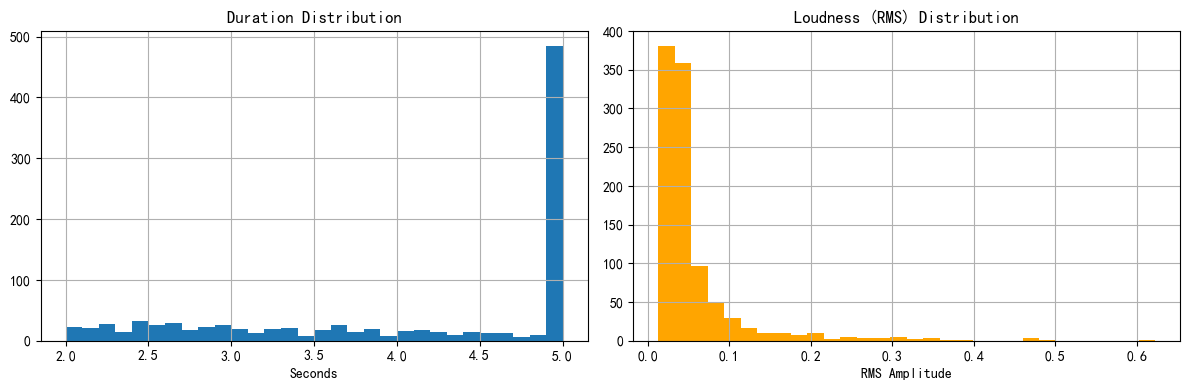

In [3]:
# ================= 配置 =================
AUDIO_DIR = Path(r"X:\数据集\OceanShip_2\Oceanship_train")
# 采样数量
SAMPLE_NUM = 1000 
# 阈值设置
TH_SILENCE = 0.005  # RMS 低于此值视为静音
TH_SHORT   = 1.0    # 短于 1 秒视为过短

# ================= 检测逻辑 =================
def analyze_quality(audio_files):
    stats = []
    
    print(f">>> 开始检测 {len(audio_files)} 个文件的信号质量...")
    
    for p in tqdm(audio_files):
        try:
            # 1. 读取音频 (使用 librosa，它会自动归一化到 -1~1)
            # sr=None 保持原始采样率，避免重采样掩盖问题
            y, sr = librosa.load(p, sr=None)
            
            # 2. 计算指标
            duration = librosa.get_duration(y=y, sr=sr)
            rms = np.sqrt(np.mean(y**2))  # 能量/响度
            max_amp = np.max(np.abs(y))   # 峰值振幅
            zcr = np.mean(librosa.feature.zero_crossing_rate(y)) # 过零率(粗略反映频率高低)
            
            # 3. 记录
            stats.append({
                'file': p.name,
                'sr': sr,
                'duration': duration,
                'rms': rms,
                'max_amp': max_amp,
                'zcr': zcr,
                'status': 'OK'
            })
            
        except Exception as e:
            print(f"[损坏] {p.name}: {e}")
            stats.append({'file': p.name, 'status': 'Corrupted'})

    return pd.DataFrame(stats)

# ================= 执行 =================
# 1. 获取文件列表
all_wavs = list(AUDIO_DIR.rglob("*.wav"))
if len(all_wavs) > SAMPLE_NUM:
    # 随机抽样
    import random
    selected_wavs = random.sample(all_wavs, SAMPLE_NUM)
else:
    selected_wavs = all_wavs

# 2. 运行分析
df_quality = analyze_quality(selected_wavs)

# ================= 结果诊断 =================
if not df_quality.empty:
    print(f"\n{'='*30}")
    print(f"📊 质量诊断报告 (样本数: {len(df_quality)})")
    print(f"{'='*30}")
    
    # 1. 采样率检查
    sr_counts = df_quality['sr'].value_counts()
    print(f"[采样率分布]\n{sr_counts}")
    if len(sr_counts) > 1:
        print("⚠️ 警告: 存在多种采样率，训练前必须统一重采样！")
        
    # 2. 静音检测 (Silent Files)
    silent_files = df_quality[df_quality['rms'] < TH_SILENCE]
    print(f"\n[过静文件] (RMS < {TH_SILENCE}): {len(silent_files)} 个")
    if len(silent_files) > 0:
        print("-> 可能是纯背景噪音，建议试听剔除。示例:", silent_files.iloc[0]['file'])
        
    # 3. 爆音检测 (Clipping)
    clipped = df_quality[df_quality['max_amp'] > 0.99]
    print(f"\n[疑似爆音] (Amp > 0.99): {len(clipped)} 个")
    
    # 4. 极短文件
    too_short = df_quality[df_quality['duration'] < TH_SHORT]
    print(f"\n[极短文件] (< {TH_SHORT}s): {len(too_short)} 个")
    
    # 5. 可视化分布
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    df_quality['duration'].hist(bins=30)
    plt.title('Duration Distribution')
    plt.xlabel('Seconds')
    
    plt.subplot(1, 2, 2)
    df_quality['rms'].hist(bins=30, color='orange')
    plt.title('Loudness (RMS) Distribution')
    plt.xlabel('RMS Amplitude')
    
    plt.tight_layout()
    plt.savefig('quality_check.png')
    print("\n已保存分布图至 quality_check.png，请查看是否有异常的双峰分布。")